## **Data Preprocessing**


### **!!!!! TODO INTRODUCERE IN DATA PREPROCESSING!!!!**

#### **Loading relational MIMIC3 tables**

- Importing the files with details of ICU patient episodes. 

In [1778]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')           # Item descriptions
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')        # ICU stay times
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) # Chart 

##### TODO choosing the disease
- Filtering for ICD-9 code 48283, corresponding to bacterial pneumonia.
- High ICU admission rates -> clinically and epidemiologically relevant for LOS modeling.
- 264 rows = 264 hospital admissions found.

In [ ]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)

df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


: 

: 

#### **Joining tables**

- Joining admissions with the respective patient data

In [ ]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 5)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO
3,605,115545,48283,2197-11-09 12:59:00,ASIAN
4,720,171046,48283,2160-02-15 21:44:00,WHITE


: 

: 

- Joining table with ICU stays
- Appending relevant patient demographics that influence the prediction

In [ ]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)
print(df_merged.shape)

df_merged.isnull().sum()


(307, 10)


SUBJECT_ID    0
HADM_ID       0
ICD9_CODE     0
ADMITTIME     0
ETHNICITY     0
ICUSTAY_ID    0
INTIME        0
LOS           0
GENDER        0
DOB           0
dtype: int64

: 

: 

#### **Feature Derivation and Data Filtering**

- Age is estimated using admission and birth year due to incomplete date precision in MIMIC-III.
- HIPAA constraints on patients ≥89 are mitigated by recoding to 91.
- Short stays (<1 day) and extreme LOS outliers are excluded to reduce heteroscedasticity and improve model generalizability.

In [ ]:
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])
df_merged['INTIME'] = pd.to_datetime(df_merged['INTIME'])
df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])

# Subtract the years
df_merged['AGE'] = (
    (df_merged['INTIME'].dt.year - df_merged['DOB'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['DOB'].dt.dayofyear) / 365.25
)

# Time since admitted in the hospital
df_merged['HOSP_TIME'] = (
    (df_merged['INTIME'].dt.year - df_merged['ADMITTIME'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_merged.loc[df_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.nsmallest(len(df_merged), 'LOS')  # Remove 2 max LOS rows 
    
df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379


: 

: 

#### **Exploratory Cohort Profiling**

- To examine the distributional extremes of ICU length of stay (LOS), the dataset was sorted in both ascending and descending order.
- Sorting to easily choose 3 patients for closely examining and charting.

In [ ]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'AGE']].head())

Top 5 Shortest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS              INTIME        AGE
287       87980   110615      243965  1.1159 2142-05-02 15:03:18  65.748118
291       94937   162005      280084  1.1432 2107-01-18 11:11:21  68.389459
244       63941   126602      270748  1.1496 2196-04-23 14:49:48  74.917864
14         3078   147024      272986  1.1541 2175-12-09 15:03:51  47.793977
29         5062   123244      250261  1.2110 2100-12-10 12:50:48  71.835044


: 

: 

In [ ]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'AGE']].head())


Top 5 Longest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS        AGE
43         6702   157559      220172  84.0409  80.644079
106       16025   155705      285837  75.7236  57.125941
53         7085   106726      283819  60.7469  42.027379
138       21312   150854      213825  55.6920  76.547570
140       22818   188392      241236  55.6687  73.405202


: 

: 

- ```.shape``` indicating the ICU stays
- ```.describe``` used for inspecting the statistics (mostly LOS and age) 

In [ ]:
df_merged.shape

(297, 10)

: 

: 

In [ ]:
# df_merged.describe().T

: 

: 

#### **Outcome Transformation**

- Log-transformation of LOS stabilizes variance and addresses right-skew 

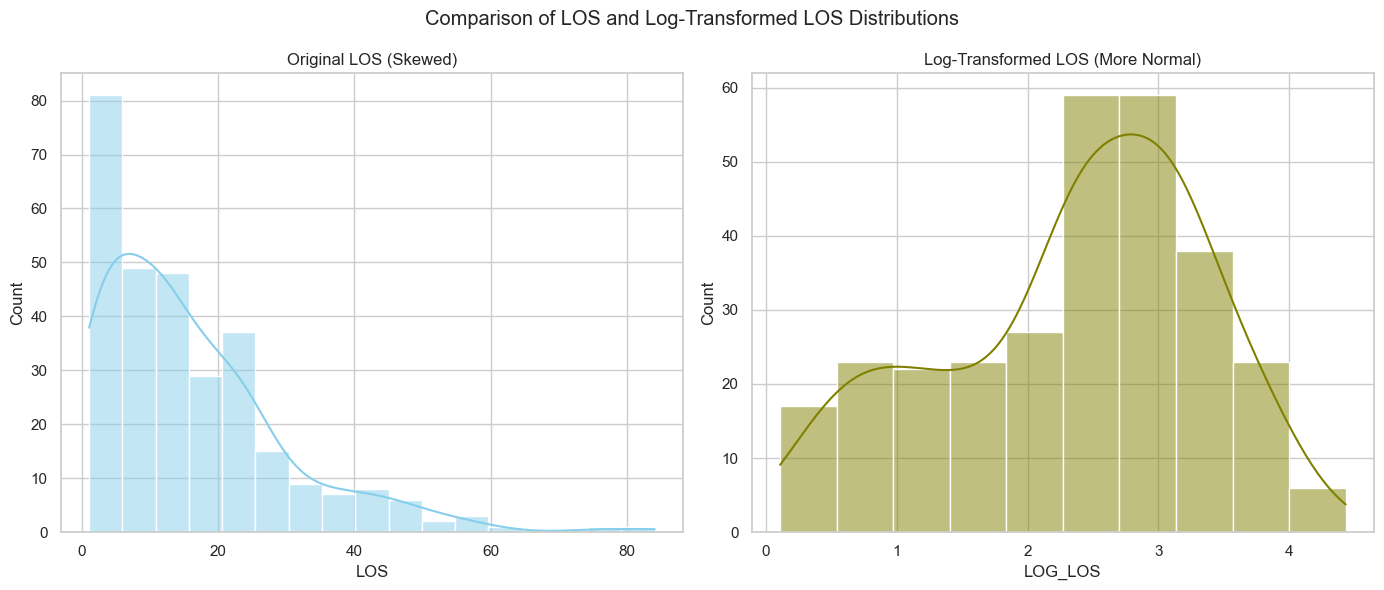

: 

: 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

- Distribution closer to Gaussian distribution, enabling the use of a wider range of models.

#### **Temporal Framing of ICU Episodes**

Three representative ICU stays were manually selected for a 24-hour observation window.  

In [ ]:
selected_small_id = 220271
selected_mean_id =  284345
selected_big_id = 200375

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22486,25628,20190,119413,200375,carevue,CCU,CSRU,57,14,2138-10-15 23:22:54,2138-11-11 12:05:15,26.5294


: 

: 

In [ ]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime

(Timestamp('2138-10-15 23:22:54'), Timestamp('2138-10-16 23:22:54'))

: 

: 

#### **Chart Data Integration and Availability Assessment**

Re-validating the merged dataset post-filtering:

In [ ]:
print(df_merged.shape)
df_merged.head()

(297, 11)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS
287,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.000000,0.109661
291,94937,162005,48283,UNKNOWN/NOT SPECIFIED,280084,2107-01-18 11:11:21,1.1432,M,68.389459,0.066393,0.133831
244,63941,126602,48283,UNKNOWN/NOT SPECIFIED,270748,2196-04-23 14:49:48,1.1496,F,74.917864,0.002738,0.139414
14,3078,147024,48283,WHITE,272986,2175-12-09 15:03:51,1.1541,M,47.793977,0.021903,0.143321
29,5062,123244,48283,WHITE,250261,2100-12-10 12:50:48,1.2110,M,71.835044,0.027379,0.191446


: 

: 

- An SQL query is executed to filter only the chartevents of the admissions with the pneumonia diagnostic into 'pneumonia.csv' for faster and easier access
- The filtered subset of the CHARTEVENTS table—specific to the pneumonia cohort is loaded. 

In [ ]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
# print(df_chart_events.shape)      
# df_chart_events.head()

: 

: 

- Joining with chart events measurements. 
- Stratification of patients into those with vs. without structured chart data.

In [ ]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

print(df_merged_with_chartevents.shape)

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 157
(986502, 16)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both
1,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both
2,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both
3,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both
4,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both


: 

: 

In [ ]:
df_final = df_merged_with_chartevents[df_merged_with_chartevents['_merge'] == 'both'].copy()

# Optional: You can now drop the '_merge' column as it's no longer needed
df_final = df_final.drop(columns=['_merge'])

print(f"Shape of the original DataFrame: {df_merged_with_chartevents.shape}")
print(f"Shape of the final DataFrame (with data): {df_final.shape}")
df_final.head()

Shape of the original DataFrame: (986502, 16)
Shape of the final DataFrame (with data): (986345, 15)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ETHNICITY,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM
0,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,220277.0,94.0,2142-05-02 15:19:00,%
1,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg
2,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg
3,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F
4,87980,110615,48283,WHITE,243965,2142-05-02 15:03:18,1.1159,M,65.748118,0.0,0.109661,223769.0,100.0,2142-05-02 15:19:00,%


: 

: 

In [ ]:
df_final.shape

(986345, 15)

: 

: 

- We can only use the ICU stays with chartevents (140), filtering out the rest
- Initially, we chose bronchitis, but too few ICU stays with chart events are not enough to train and validate the model
![Alt Text](./bronchitis_results.png)

#### **First 24 hour ICU window**

- creating the patients first 24 hour window in ICU
- analyzing the number of items administrated during this window

(92007, 16)


<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

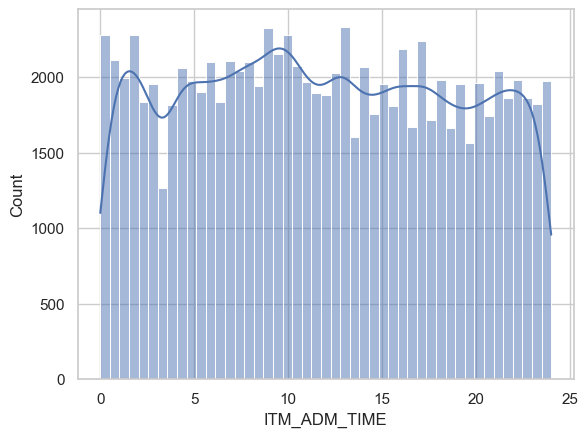

: 

: 

In [ ]:
df_final['INTIME'] = pd.to_datetime(df_final['INTIME'])
df_final['CHARTTIME'] = pd.to_datetime(df_final['CHARTTIME'])

# df_final.isnull().sum()

df_final['ITM_ADM_TIME'] = (df_final['CHARTTIME'] - df_final['INTIME']).dt.total_seconds() / 3600
df_final = df_final[(df_final['ITM_ADM_TIME'] <= 24) & (df_final['ITM_ADM_TIME'] >= 0)]
# df_merged_with_chartevents.describe()

print(df_final.shape)
sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

- normalizing the window time to a (0, 1) interval
- makes a larger variety of models easier to be trained
- it's easier to interpret results this way

<Axes: xlabel='ITM_ADM_TIME', ylabel='Count'>

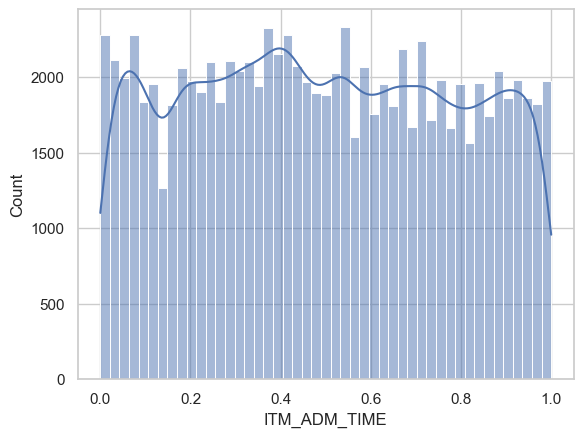

: 

: 

In [ ]:
df_final['ITM_ADM_TIME'] = df_final['ITM_ADM_TIME'] / 24.0

sns.histplot(df_final['ITM_ADM_TIME'], kde=True)

#### **Choosing 3 patients**

- chose 3 patients with little, medium and high length of stay in the time window in order to visualise different trends

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# Load the dataset once
df = pd.read_csv("./data_sets/norm_pneumonia.csv")
df['ITM_ADM_TIME'] = df['NORMTIME']
df.drop(columns='NORMTIME')
# Define plotting function
def plot_icu_data(icu_id):
    filtered = df[df["ICUSTAY_ID"] == icu_id]
    value_min = 0
    value_max = 200
    filtered_limited = filtered[
        (filtered["VALUENUM"] >= value_min) & (filtered["VALUENUM"] <= value_max)
    ]

    # Prepare LOWESS smoothed values
    x = filtered_limited["ITM_ADM_TIME"]
    y = filtered_limited["VALUENUM"]
    lowess_smoothed = lowess(y, x, frac=0.3, return_sorted=True)
    lowess_x = lowess_smoothed[:, 0]
    lowess_y = lowess_smoothed[:, 1]

    # Bootstrap for confidence interval
    bootstraps = []
    for _ in range(100):
        sample = filtered_limited.sample(frac=1, replace=True)
        smoothed = lowess(sample["VALUENUM"], sample["ITM_ADM_TIME"], frac=0.3, return_sorted=True)
        bootstraps.append(np.interp(lowess_x, smoothed[:, 0], smoothed[:, 1]))
    bootstraps = np.array(bootstraps)
    ci_lower = np.percentile(bootstraps, 2.5, axis=0)
    ci_upper = np.percentile(bootstraps, 97.5, axis=0)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.set(style="whitegrid")

    sns.scatterplot(
        data=filtered_limited,
        x="ITM_ADM_TIME",
        y="VALUENUM",
        hue="ITEMID",
        palette="Blues",
        alpha=0.8
    )

    # Add LOWESS trend line
    plt.plot(lowess_x, lowess_y, color="blue", label="Trend")

    # Add ribbon (confidence interval)
    plt.fill_between(lowess_x, ci_lower, ci_upper, color="blue", alpha=0.2, label="95% CI")

    # Adjust legend
    plt.legend(title="ITEMID", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"ICU_{icu_id}", fontsize=16)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()


: 

: 

##### Little length of stay

/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


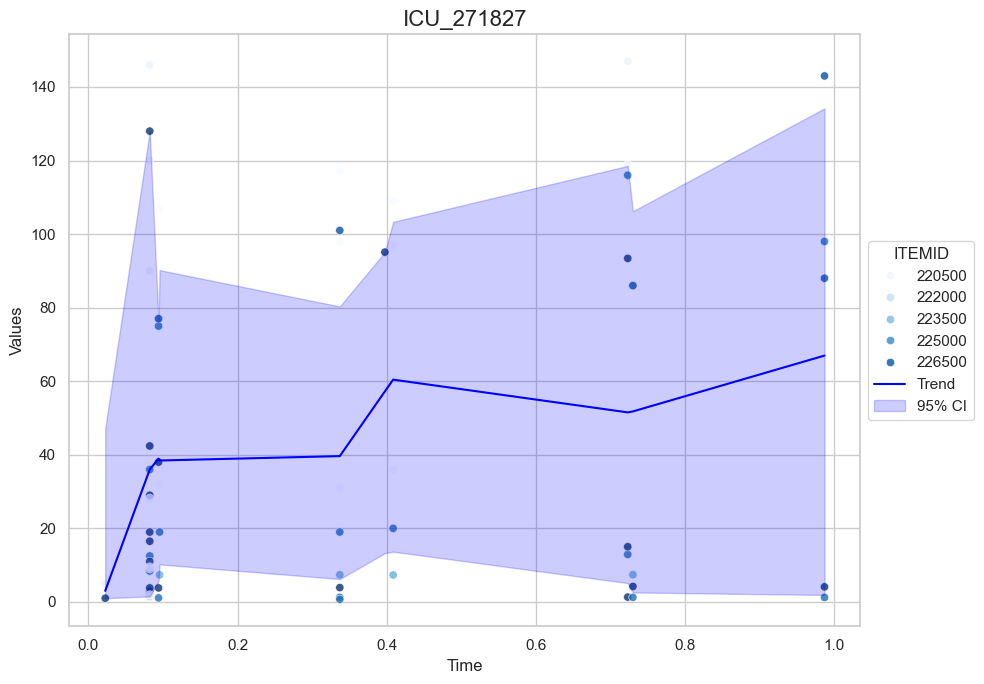

: 

: 

In [ ]:
plot_icu_data(icu_id=271827)


**Trend Analysis**
- LOESS trend shows a slight **increase** over time, with a **sharp jump** around the 0.4 mark.
- The trend is **unstable** due to sparse data and high variability.

**Confidence Interval**
- Fluctuations are less reliable because of the few observations across time.

**Data Distribution**
- Dense concentration of measurements in the early stages (Time: 0–0.2).
- Sparse or no data toward later time points.
- ITEMIDs show **diverse value ranges**, including some extreme outliers.

**Statistical Summary**
- Likely high **variance** and **skew** in values.
- Mean and trend are **strongly influenced** by early data.
- Not ideal for modeling due to **poor signal regularity** and limited time coverage.


##### Medium length of stay

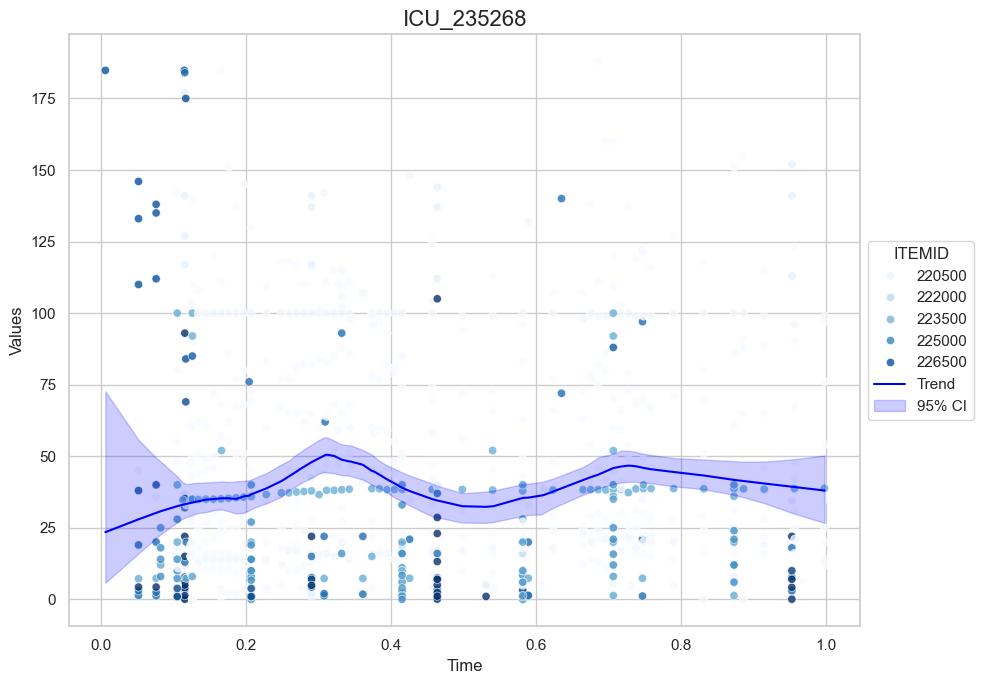

: 

: 

In [ ]:
plot_icu_data(icu_id=235268)

**Trend Analysis**
- LOESS trend displays a **well-formed curve**, peaking around 0.35 and slightly rising again near the end.
- Overall smooth and **consistent trajectory**.

**Confidence Interval**
- Reliable trend estimation is possible.

**Data Distribution**
- Measurements are **evenly spread** over the entire ICU stay.
- ITEMIDs contribute a **balanced** distribution of values.
- Fewer outliers; the bulk of values appear in a **central band**.

**Statistical Summary**
- **Low variance**, relatively **normal distribution**.
- **High trend confidence** suggests this group is suitable for predictive modeling.
- Reflects **stable and systematic monitoring** over time.


##### High length of stay

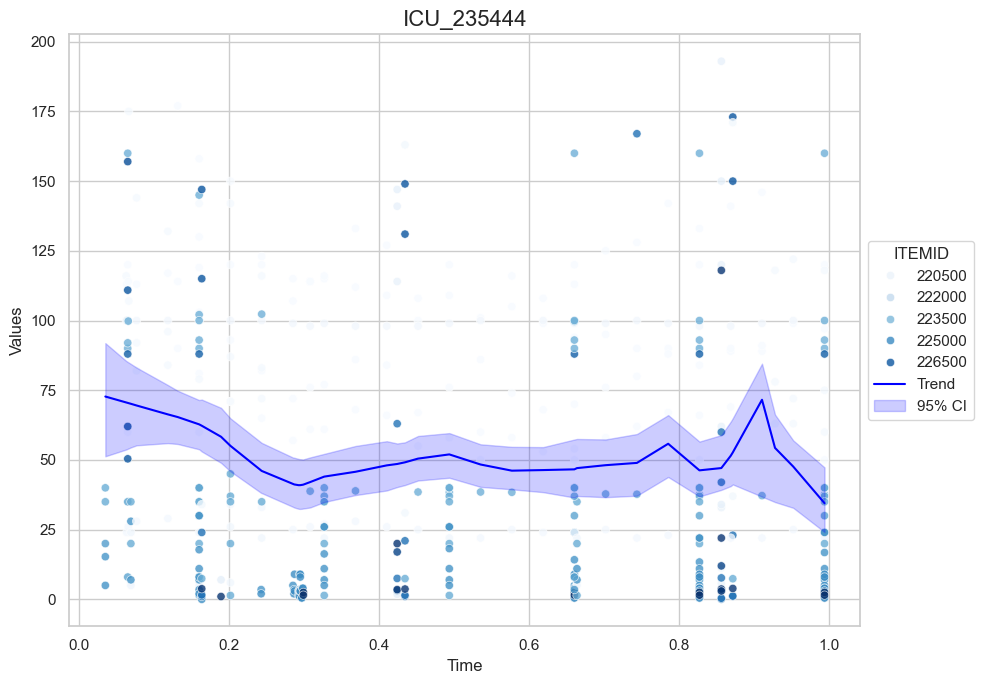

: 

: 

In [ ]:
plot_icu_data(icu_id=235444)

**Trend Analysis**
- Trend line shows a **slight downward slope**, with a brief upward spike near 0.9.
- Suggests overall **decline in measured values**, possibly due to treatment effects.

**Confidence Interval**
- Indicates **greater variability** in measurement trends over time.

**Data Distribution**
- High density of points throughout the entire time window.
- More **outliers** present, including values above 150.
- ITEMID values are **widely distributed**.

**Statistical Summary**
- **Moderate to high variance**.
- Trend shows signs of **late-stage variability** in ICU stay.
- Pattern reflects long-term patients with **fluctuating or deteriorating conditions**.

### **Feature Engineering**

### !!!!! TODO INTRODUCERE!!!

#### **Categorical Variable Transformation and Encoding**

- Age harmonization
- Filtering of implausible or extreme values
- Ethnicity profiling
    - Rare ethnicity subgroups were consolidated under a single 'OTHER' category to reduce class imbalance and categorical sparsity.


In [ ]:
df_final.loc[df_final['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_final = df_final[df_final['LOS'] > 1]

df_final = df_final.nsmallest(len(df_final), 'LOS')  # Remove 2 max LOS rows   

unique_ethnicities = df_final['ETHNICITY'].unique()
print(unique_ethnicities)

ethnicity_counts = df_final['ETHNICITY'].value_counts()
print(ethnicity_counts)

# df_merged.head()

df_final.shape

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'BLACK/AFRICAN AMERICAN'
 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN' 'HISPANIC OR LATINO'
 'WHITE - RUSSIAN' 'UNABLE TO OBTAIN' 'ASIAN - CHINESE' 'OTHER'
 'PATIENT DECLINED TO ANSWER']
ETHNICITY
WHITE                             77730
BLACK/AFRICAN AMERICAN             5450
UNKNOWN/NOT SPECIFIED              2309
HISPANIC OR LATINO                 1810
ASIAN                              1268
OTHER                               883
WHITE - RUSSIAN                     813
UNABLE TO OBTAIN                    753
PATIENT DECLINED TO ANSWER          400
ASIAN - CHINESE                     376
HISPANIC/LATINO - PUERTO RICAN      215
Name: count, dtype: int64


(92007, 16)

: 

: 

In [ ]:
# List rare ethnicities (adjust threshold as needed)
rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# Consolidate
df_final['ETHNICITY'] = df_final['ETHNICITY'].replace(rare_ethnicities, 'OTHER')
# df_merged.head()

: 

: 

- ```GENDER``` variable was encoded using LabelEncoder, converting categorical values into binary numeric form
- The ```ETHNICITY``` variable was transformed via one-hot encoding, producing binary indicator variables for each category.
- The argument ```drop_first=True``` 
    - prevents multicollinearity;
    - makes it usable with a wider range of models

In [ ]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()

df_final['GENDER'] = gender_encoder.fit_transform(df_final['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_final = pd.get_dummies(
    df_final, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )

# print(df_merged.isnull().sum())

# df_merged.head()
df_final.shape

Gender Classes: ['F' 'M']


(92007, 20)

: 

: 

#### **Diving deeper into features**

- No severe age-related outliers are present
- Good, close to Gaussian distribution

<Axes: xlabel='AGE', ylabel='Count'>

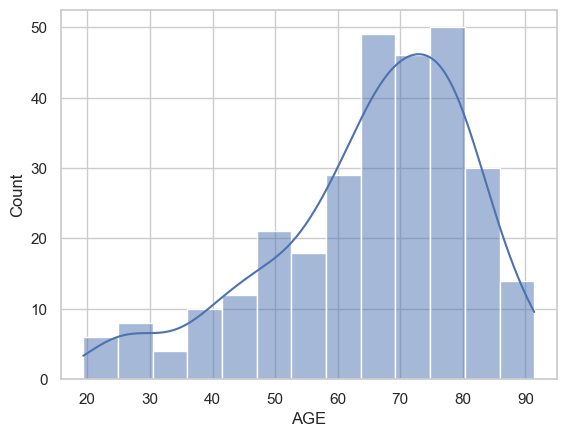

: 

: 

In [ ]:
sns.histplot(df_merged['AGE'], kde=True)

- Preparation for aggregating time series features:

In [ ]:
df_final.head()


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,HOSP_TIME,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,ITM_ADM_TIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
0,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,0.109661,220277.0,94.00,2142-05-02 15:19:00,%,0.010903,False,False,False,False,True
172,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,0.109661,227457.0,196.00,2142-05-03 05:20:00,K/uL,0.594931,False,False,False,False,True
173,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,0.109661,220734.0,5.50,2142-05-03 05:21:00,units,0.595625,False,False,False,False,True
174,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,0.109661,227471.0,1.01,2142-05-03 05:21:00,NaN,0.595625,False,False,False,False,True
175,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,0.109661,220045.0,77.00,2142-05-03 06:00:00,bpm,0.622708,False,False,False,False,True


: 

: 

In [ ]:
static_features = df_final.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])[
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','HOSP_TIME', 'AGE', 'GENDER', 
     'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 
     'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE','LOS', 'LOG_LOS']
]

static_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOS,LOG_LOS
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,True,1.1159,0.109661
447,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,False,1.1432,0.133831
765,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,False,1.1496,0.139414
1067,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,False,1.2523,0.224982
1309,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,False,1.2891,0.253944


: 

: 

#### **Construction of patient-level feature matrix**

- Aggregates time-series measurements into summary features, enabling models to use sequential ICU data in fixed-length format.

- Captures temporal patterns through trend estimation, which helps quantify clinical trajectories over the first 24 hours.

- Computes multiple statistical descriptors (e.g., mean, std, range) to represent variability and central tendency of physiological signals.

- Allows selection of specific aggregation types, offering flexibility based on modeling needs.

- Preserves alignment between time-series features and static patient data through patient-level merging.

- Ensures robustness by filling missing values with zeros, preventing shape mismatches or training instability.

- Produces a unified, flat feature matrix suitable for classical machine learning algorithms.


In [ ]:
import pandas as pd
import numpy as np

# This function now correctly expects a list of IDs for the third argument.
# The 'features_df' (for mapping names) is now a separate, optional argument.
def create_feature_matrix(df_events, df_static, item_ids, features_df=None, agg_list=None):
    """
    Creates a feature matrix by combining static data with aggregated time-series features.
    This version correctly accepts a list of ITEMIDs and robustly flattens MultiIndex columns.

    Args:
        df_events (pd.DataFrame): Time-series data with 'SUBJECT_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'.
        df_static (pd.DataFrame): Static patient data with 'SUBJECT_ID'.
        item_ids (list): A Python list of ITEMIDs to use for feature generation.
        features_df (pd.DataFrame, optional): For mapping ITEMID to readable names. 
                                               Must have 'ITEMID' and 'item_name' columns. Defaults to None.
        agg_list (list, optional): Aggregations to compute. Defaults to ['mean', 'std', 'count', 'range', 'trend'].

    Returns:
        pd.DataFrame: Combined static + aggregated features, with NaN filled as 0.
    """
    if agg_list is None:
        agg_list = ['mean', 'std', 'count', 'range', 'trend']

    # 1. Filter relevant ITEMIDs from the provided list
    df_filtered = df_events[df_events['ITEMID'].isin(item_ids)].copy()
    df_filtered['CHARTTIME'] = pd.to_datetime(df_filtered['CHARTTIME'])

    # 2. Define aggregation calculations (no changes here)
    def calculate_aggregated_features(group):
        vals = group['VALUENUM']
        count = vals.count()
        features = {}
        for agg in agg_list:
            features[agg] = 0
        if count == 0:
            return pd.Series(features)
        if 'count' in agg_list: features['count'] = count
        if 'mean' in agg_list: features['mean'] = vals.mean()
        if 'std' in agg_list: features['std'] = vals.std() if count > 1 else 0
        if 'range' in agg_list: features['range'] = vals.max() - vals.min() if count > 1 else 0
        if 'trend' in agg_list and count > 1:
            group = group.sort_values('CHARTTIME')
            time_in_hours = (group['CHARTTIME'] - group['CHARTTIME'].iloc[0]).dt.total_seconds() / 3600.0
            valid_indices = time_in_hours.notna() & vals.notna()
            if valid_indices.sum() > 1:
                slope = np.polyfit(time_in_hours[valid_indices], vals[valid_indices], 1)[0]
                features['trend'] = slope if np.isfinite(slope) else 0
        return pd.Series(features)

    # 3. Compute aggregations
    item_stats = (
        df_filtered.groupby(['SUBJECT_ID', 'ITEMID'])
        .apply(calculate_aggregated_features)
        .unstack(fill_value=0)
    )
    
    # 4. Flatten MultiIndex columns (Robust Fix)
    if isinstance(item_stats.columns, pd.MultiIndex):
        if features_df is not None:
            # Ensure data types match for mapping
            features_df['ITEMID'] = features_df['ITEMID'].astype(int)
            itemid_to_label = dict(zip(features_df['ITEMID'], features_df['item_name']))
            item_stats.columns = [
                f"{agg}_{itemid_to_label.get(int(itemid), f'ITEM_{itemid}')}"
                for agg, itemid in item_stats.columns
            ]
        else: # If no features_df is provided, use default names
            item_stats.columns = [
                f"{agg}_ITEM_{itemid}" for agg, itemid in item_stats.columns
            ]

    item_stats = item_stats.reset_index()

    # 5. Merge with static data
    model_data = pd.merge(
        df_static,
        item_stats,
        on='SUBJECT_ID',
        how='left'
    ).fillna(0)

    return model_data

: 

: 

In [ ]:
top30_features_df = pd.read_csv(data_path + 'items_appearance_pneumonia.csv')

top30_features_df.head()

,rank,ITEMID,item_name,VALUEUOM,stay_count
0,1,220645.0,Sodium (serum),mEq/L,135
1,2,220615.0,Creatinine,mg/dL,135
2,3,220602.0,Chloride (serum),mEq/L,135
3,4,225624.0,BUN,mg/dL,135
4,5,227443.0,HCO3 (serum),mEq/L,135


: 

: 

We chose the top 32 met items:

In [ ]:
top30_features = top30_features_df[top30_features_df['rank'] <= 32]['ITEMID'].to_list()

print('The number of items is: ', len(top30_features))

The number of items is:  32


: 

: 

In [ ]:
model_data_full = create_feature_matrix(
    df_merged_with_chartevents,
    static_features,
    top30_features, # The list of ITEMIDs
    features_df=top30_features_df # The dataframe for naming (optional)
)
print(model_data_full.shape)
model_data_full.head()

(140, 173)


/var/folders/3h/2yy19zsd15q4cksyddkdpd_00000gn/T/ipykernel_5037/4268334774.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_aggregated_features)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HOSP_TIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Calcium non-ionized,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,...,-0.053503,0.000000,0.000000,-2.495307e-15,-0.152866,-0.061146,-0.076433,0.305732,0.000000,0.000000
1,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,...,0.001131,-0.001769,-0.000688,1.568154e-04,-0.000198,-0.000275,0.000209,0.019302,-0.001110,-0.000114
2,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,...,0.000000,0.000000,0.000000,2.405895e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,...,0.000661,-0.001019,0.026978,1.552880e-03,-0.005431,0.000708,0.013959,0.219447,-0.001182,-0.000104
4,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,...,0.000000,0.000000,0.000000,-9.136212e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


: 

: 

#### Removal of low variance features

- Removes features with low variance across ICU stays, as they offer little to no discriminatory power.

- Keeps only variables that vary meaningfully across patients, increasing model relevance.

- Reduces feature dimensionality, lowering computational cost and risk of overfitting.

- Improves signal-to-noise ratio by discarding non-informative or redundant predictors.

- Enhances generalization by ensuring models are not trained on constant or nearly constant features.

- Logs dropped features for transparency and potential clinical interpretation of low-variability signals.


In [ ]:
from sklearn.feature_selection import VarianceThreshold
# only works on numerical features
selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance

non_numerical_feature_cols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOG_LOS']

feature_cols = [col for col in model_data_full.columns if col not in non_numerical_feature_cols]

features_df = model_data_full[feature_cols]
selector.fit(features_df)

kept_cols = features_df.columns[selector.get_support()]

print(f"Original number of features: {len(feature_cols)}")
print(f"Number of features kept: {len(kept_cols)}")

final_cols_to_keep = non_numerical_feature_cols + kept_cols.tolist()
df_selected = model_data_full[final_cols_to_keep]
# df_selected = model_data_full
print("\nShape of the new DataFrame:", df_selected.shape)
print("\nFirst 5 rows of the new DataFrame with selected features:")
# print(df_selected.head())

Original number of features: 169
Number of features kept: 142

Shape of the new DataFrame: (140, 146)

First 5 rows of the new DataFrame with selected features:


: 

: 

In [ ]:
dropped_cols_mask = ~selector.get_support()
dropped_cols = features_df.columns[dropped_cols_mask]
# Dropped columns
dropped_cols

Index(['HOSP_TIME', 'std_PH (Arterial)', 'trend_Heart Rate Alarm - Low',
       'trend_Respiratory Rate', 'trend_Hemoglobin',
       'trend_O2 saturation pulseoxymetry', 'trend_Hematocrit (serum)',
       'trend_WBC', 'trend_Chloride (serum)', 'trend_Creatinine',
       'trend_Magnesium', 'trend_Sodium (serum)',
       'trend_O2 Saturation Pulseoxymetry Alarm - High',
       'trend_O2 Saturation Pulseoxymetry Alarm - Low', 'trend_PH (Arterial)',
       'trend_Resp Alarm - High', 'trend_Resp Alarm - Low',
       'trend_Arterial Base Excess', 'trend_Calcium non-ionized',
       'trend_Phosphorous', 'trend_TCO2 (calc) Arterial',
       'trend_SpO2 Desat Limit', 'trend_Anion gap', 'trend_Potassium (serum)',
       'trend_HCO3 (serum)', 'trend_Prothrombin time', 'trend_INR'],
      dtype='object')

: 

: 

#### Correlation Filtering

- Computes the absolute correlation matrix between all numeric features to identify redundancy.

- Visualizes feature interdependence through a heatmap, highlighting clusters of highly correlated variables.

- Identifies features with pairwise correlation above 0.9 and marks them for removal to reduce multicollinearity.

- Retains only one feature per highly correlated pair/group, reducing dimensional redundancy.

- Helps stabilize model coefficients and prevents inflated feature importance in linear models.

- Results in a leaner feature matrix that is more interpretable and less prone to overfitting.

- Logs the names of dropped features to ensure reproducibility and transparency in the feature selection process.


Generating heatmap for features before correlation-based removal...


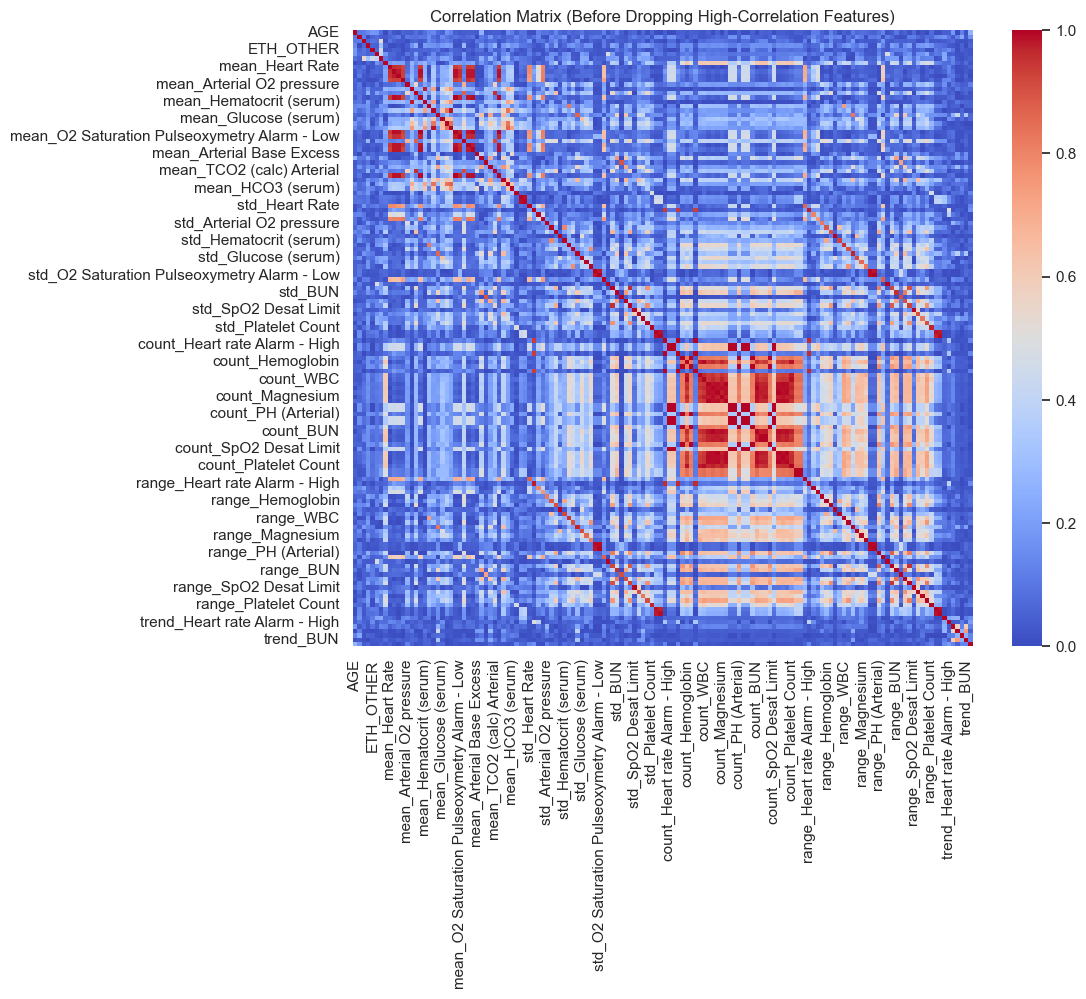

: 

: 

In [ ]:
X = df_selected.drop(columns=non_numerical_feature_cols)

corr_matrix = X.corr().abs()

print("Generating heatmap for features before correlation-based removal...")

plt.figure(figsize=(10, 8))  # Adjust size as needed for readability
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=True can be used for smaller matrices
plt.title('Correlation Matrix (Before Dropping High-Correlation Features)')
plt.show()

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Number of features to drop due to high correlation: {len(to_drop)}")
print("Columns being dropped:", to_drop)


Number of features to drop due to high correlation: 66
Columns being dropped: ['mean_Heart rate Alarm - High', 'mean_Heart Rate Alarm - Low', 'mean_Respiratory Rate', 'mean_O2 saturation pulseoxymetry', 'mean_Hematocrit (serum)', 'mean_Sodium (serum)', 'mean_O2 Saturation Pulseoxymetry Alarm - High', 'mean_O2 Saturation Pulseoxymetry Alarm - Low', 'mean_Resp Alarm - High', 'mean_Resp Alarm - Low', 'mean_TCO2 (calc) Arterial', 'mean_SpO2 Desat Limit', 'mean_INR', 'std_O2 Saturation Pulseoxymetry Alarm - Low', 'std_TCO2 (calc) Arterial', 'std_INR', 'count_Heart Rate', 'count_Heart Rate Alarm - Low', 'count_Respiratory Rate', 'count_Arterial CO2 Pressure', 'count_O2 saturation pulseoxymetry', 'count_Hematocrit (serum)', 'count_WBC', 'count_Chloride (serum)', 'count_Creatinine', 'count_Glucose (serum)', 'count_Magnesium', 'count_Sodium (serum)', 'count_O2 Saturation Pulseoxymetry Alarm - High', 'count_O2 Saturation Pulseoxymetry Alarm - Low', 'count_PH (Arterial)', 'count_Resp Alarm - High

: 

: 

In [ ]:
df_final_selected_copy = df_selected.drop(columns=to_drop)
df_final_selected = df_selected

print(f"\nFinal number of features: {df_final_selected_copy.shape[1] - len(non_numerical_feature_cols)}")
print("Shape of the final DataFrame:", df_final_selected_copy.shape)
print("\nFirst 5 rows of the final DataFrame:")
df_final_selected.head()


Final number of features: 76
Shape of the final DataFrame: (140, 80)

First 5 rows of the final DataFrame:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOG_LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,range_Platelet Count,range_Prothrombin time,range_INR,trend_Heart Rate,trend_Heart rate Alarm - High,trend_Arterial O2 pressure,trend_Arterial CO2 Pressure,trend_Glucose (serum),trend_BUN,trend_Platelet Count
0,87980,110615,243965,0.109661,65.748118,1,False,False,False,False,...,4.0,0.0,0.0,0.047154,-1.663538e-15,0.000000,0.00000,1.910828,-0.382166,0.305732
1,94937,162005,280084,0.133831,68.389459,1,False,False,False,True,...,339.0,3.5,0.4,0.013426,5.332194e-03,-0.182553,-0.01449,0.040292,0.018439,0.019302
2,63941,126602,270748,0.139414,74.917864,0,False,False,False,True,...,0.0,0.0,0.0,0.059482,3.165939e-01,0.000000,0.00000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.224982,76.251882,1,True,False,False,False,...,147.0,4.6,0.5,-0.034946,-8.145970e-03,-0.013758,0.02537,-0.016766,-0.014462,0.219447
4,26855,112153,200612,0.253944,66.260096,0,False,False,False,True,...,0.0,0.0,0.0,0.730189,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000


: 

: 

- **Isolate relevant features**:  
  Start from the dataset already filtered for low-variance features, and isolate only the numerical feature columns into a new DataFrame.

- **Compute correlation matrix**:  
  Calculate the absolute Pearson correlation matrix for `X`, focusing on correlation strength regardless of direction.

- **Mask the upper triangle**:  
  Use the upper triangle of the correlation matrix to avoid checking redundant pairs, since the matrix is symmetric.

- **Identify highly correlated features**:  
  Iterate through the upper triangle and flag features for removal if they have a correlation above 0.9 with any other feature in the matrix.

- **Drop redundant features**:  
  Remove the flagged features from the dataset to obtain the final cleaned feature set, ensuring reduced multicollinearity and more stable model training.



Generating heatmap for the final set of features...


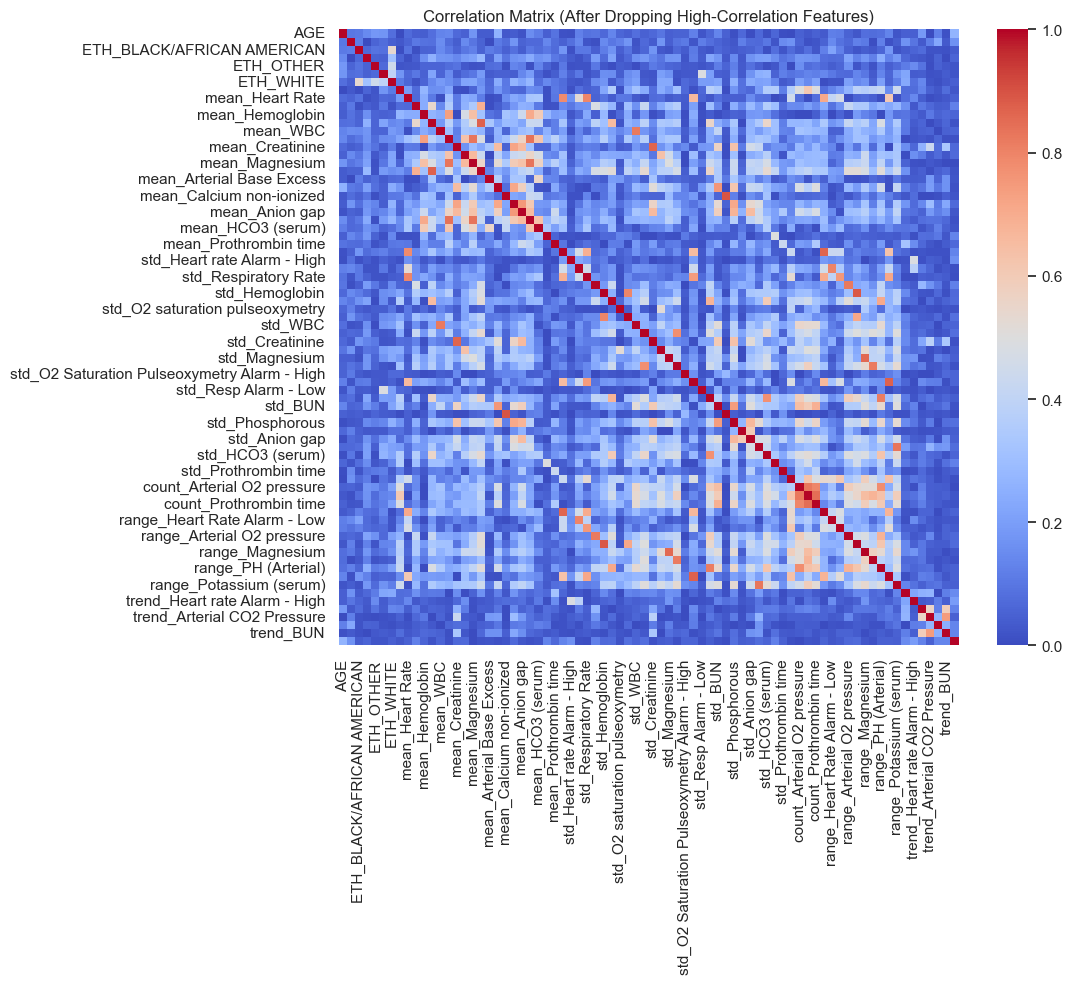

: 

: 

In [ ]:
final_features = df_final_selected_copy.drop(columns=non_numerical_feature_cols)

# Calculate the new correlation matrix
final_corr_matrix = final_features.corr().abs()

print("\nGenerating heatmap for the final set of features...")

plt.figure(figsize=(10, 8)) # Can be a bit smaller as there are fewer features
sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Correlation Matrix (After Dropping High-Correlation Features)')
plt.show()

In [ ]:
df_final_selected.shape

(140, 146)

: 

: 

#### **Model-Based Feature Selection Using Permutation Importance**

- Trains a gradient boosting regression model (XGBoost) to predict the target variable (`LOS`).

- Uses `GroupKFold` cross-validation to ensure patient groups (e.g., `SUBJECT_ID`) are not split across training and validation sets.

- Evaluates the model on a validation fold and computes **permutation importance** — a measure of how much shuffling each feature affects model performance.

- Converts raw importances to relative contributions by normalizing them across all features.

- Retains only features that contribute at least 1% to predictive performance, reducing noise and focusing the model on relevant variables.

- Returns a reduced dataset with only the most informative features, improving training efficiency and generalization in downstream models.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

def filter_low_importance_features(df, target_column, group_column=None, threshold=0.01, n_splits=5):
    y = df[target_column]
    X = df.drop(columns=[target_column,'HADM_ID','SUBJECT_ID','ICUSTAY_ID','LOG_LOS'])
    
    groups = df[group_column] if group_column else np.arange(len(df))

    # Initialize GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    model = XGBRegressor(n_estimators=1000, early_stopping_rounds=10, eval_metric='rmse', verbosity=0)

    # Use first fold for early stopping
    train_idx, val_idx = next(gkf.split(X, y, groups))
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Compute permutation importance
    result = permutation_importance(model, X_val, y_val, n_repeats=5, scoring='neg_root_mean_squared_error', random_state=42)
    importances = result.importances_mean

    # Compute relative importances
    relative_importances = importances / np.sum(importances)

    # Select features with >= 1% contribution
    important_features = X.columns[relative_importances >= threshold]
    print(f"Retaining {len(important_features)} features out of {X.shape[1]}")

    return df[important_features.tolist() + [target_column]]

# Example usage:
df_final_selected = filter_low_importance_features(df_final_selected, target_column='LOS', group_column='SUBJECT_ID',threshold = 0.01)

KeyError: "['HADM_ID', 'SUBJECT_ID', 'ICUSTAY_ID', 'LOG_LOS'] not found in axis"

: 

: 

In [ ]:
df_final_selected.head()

,mean_Platelet Count,std_TCO2 (calc) Arterial,count_Hemoglobin,count_Hematocrit (serum),count_Magnesium,count_Anion gap,trend_Glucose (serum),LOS
0,194.000000,0.000000,2.0,2.0,2.0,2.0,1.910828,1.1159
1,202.111111,3.043409,27.0,37.0,36.0,31.0,0.040292,1.1432
2,526.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,1.1496
3,218.227273,4.905149,22.0,23.0,26.0,27.0,-0.016766,1.2523
4,211.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,1.2891


: 

: 

#### **Model Training, Evaluation, and Interpretability Analysis**

- Splits the final feature matrix into training and testing subsets to evaluate generalization on unseen data.

- Uses `GridSearchCV` with cross-validation to identify the best hyperparameters for an XGBoost regression model.

- Evaluates model performance using standard regression metrics:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - R-squared (R²)

- Reports a final RMSE of ~7 days, reflecting prediction error in ICU length of stay.

- Applies SHAP (SHapley Additive exPlanations) to estimate the contribution of each feature to model output.

- Visualizes the global importance of top features using a SHAP beeswarm plot, enabling interpretable assessment of model behavior.

- Identifies features such as `mean_Platelet Count`, `mean_Heart Rate`, and `trend_Heart rate Alarm - High` as key drivers of prediction variance.


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

df_perm_selected = df_final_selected
# --- 1. Prepare Data ---
# Assume 'df_perm_selected' is your final DataFrame
X = df_perm_selected.drop(columns='LOS')
print(X.columns)
y = df_perm_selected['LOS']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Define GridSearchCV ---
params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'reg_alpha': [0.1]
}

xgb = XGBRegressor(random_state=42)
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running GridSearchCV to find the best model...")
model = GridSearchCV(estimator=xgb, param_grid=params, cv=cv_splitter, scoring='neg_root_mean_squared_error', n_jobs=-1)
model.fit(X_train, y_train)
print("GridSearchCV complete.")

# --- 3. Evaluate the Best Model on the Test Set ---
best_model = model.best_estimator_

# Use the best model to predict on the unseen test set
predictions_log = best_model.predict(X_test)

# Convert both the predictions and the true test labels back to days
predictions_days = (predictions_log)
y_test_days = (y_test)

# --- Calculate all three metrics on the original 'days' scale ---
final_mae = mean_absolute_error(y_test_days, predictions_days)
final_mse = mean_squared_error(y_test_days, predictions_days)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test_days, predictions_days)

# --- 4. Report All Results ---
print(f"\nBest parameters found: {model.best_params_}")
print("\n--- Final Model Performance on Hold-Out Test Set ---")
print(f"Mean Absolute Error (MAE): {final_mae:.4f} days")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.4f} days")
print(f"R-squared (R²): {final_r2:.4f}")

Index(['mean_Platelet Count', 'std_TCO2 (calc) Arterial', 'count_Hemoglobin',
       'count_Hematocrit (serum)', 'count_Magnesium', 'count_Anion gap',
       'trend_Glucose (serum)'],
      dtype='object')
Running GridSearchCV to find the best model...


/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/bin/python: Error while finding module specification for 'joblib.externals.loky.backend.popen_loky_posix' (ModuleNotFoundError: No module named 'joblib')
/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/bin/python: Error while finding module specification for 'joblib.externals.loky.backend.popen_loky_posix' (ModuleNotFoundError: No module named 'joblib')
/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/bin/python: Error while finding module specification for 'joblib.externals.loky.backend.popen_loky_posix' (ModuleNotFoundError: No module named 'joblib')
/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/bin/python: Error while finding module specification for 'joblib.externals.loky.backend.popen_loky_posix' (ModuleNotFoundError: No module named 'joblib')
/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/bin/pytho

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1), EXIT(1), EXIT(1), EXIT(1)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

: 

: 

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

: 

: 